In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

In [127]:
dir = "/home/menonsandu/idls_results/"
for file in os.listdir(dir):
    if file.startswith("GAN_server_"):
        # Rename the folder
        os.rename(os.path.join(dir, file), os.path.join(dir, file.replace("GAN_server_", "")))

In [157]:
def get_all_fids(folder_path):
    fids = {}
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            epoch_num = file.replace(".txt", "")
            epoch_num = epoch_num.replace("fid_results", "")
            epoch_num = epoch_num.replace("_", "")
            with open (os.path.join(folder_path, file), "r") as myfile:
                data=myfile.readlines()
                # print(folder_path, file, data)
                if len(data) == 0:
                    print("FID not found for ", folder_path, file)
                    continue
                elif len(data) == 1:
                    fid = data[0].replace("FID:  ", "")
                    fid = fid.rstrip()
                else:
                    fid = data[1].replace("FID:  ", "")
                    fid = fid.rstrip()

                fids[int(epoch_num)] = float(fid)
    

    # Choose the best FID after 100 rounds
    if 100 in fids:
        min_fid_post100 = min(fids.values())
        fids[100] = min_fid_post100
        # Remove all the FIDs above 100
        fids = {k: v for k, v in fids.items() if k <= 100}
            
    return fids

In [158]:
def read_results(results_dir, dataset):
    iid_results = {}
    noniid_results = {}
    fedbn_results = {}
    for folder in os.listdir(results_dir):
        if folder.startswith(f"{dataset}"):
            num_clients = int(folder.split("_")[2])
            beta_val = folder.split("_")[3]
            if beta_val[0] == "0":
                beta_val = eval(f"0.{beta_val[1]}")
            else:
                beta_val = eval(beta_val)
            is_noniid = len(folder.split("_")) > 4 and folder.split("_")[4] == "noniid"
            isfedbn = folder.split("_")[-1] == "fedbn"
            fids = get_all_fids(os.path.join(results_dir, folder))

            if isfedbn:
                fedbn_results[num_clients] = fids
            elif not is_noniid:
                iid_results[num_clients] = fids
            else:
                if beta_val not in noniid_results:
                    noniid_results[beta_val] = {}
                    noniid_results[beta_val][num_clients] = fids
                else:
                    noniid_results[beta_val][num_clients] = fids

    return iid_results, noniid_results, fedbn_results




In [134]:
# Basic FL GAN results
results_dir = "/home/menonsandu/idls_results"
dataset = "mnist"
# MNIST results
iid_results, noniid_results, fedbn_results = read_results(results_dir, "mnist")
# CIFAR10 results
iid_results_cifar, noniid_results_cifar, fedbn_results_cifar = read_results(results_dir, "cifar")

In [ ]:
iid_results_cifar, noniid_results_cifar, fedbn_results_cifar

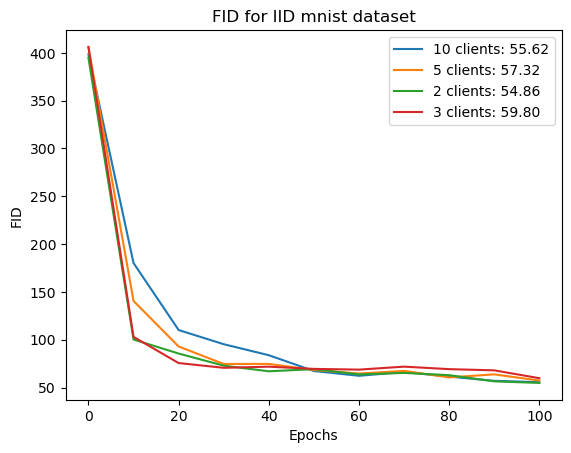

In [137]:
# Plot iid results for each number of clients
for num_clients in iid_results.keys():
    fid_epoch_dict = iid_results[num_clients]
    max_epoch = max(fid_epoch_dict.keys())
    epochs = range(0, max_epoch + 1, 10)
    fids = [fid_epoch_dict[e] for e in epochs]
    plt.plot(epochs, fids, label=f"{num_clients} clients: {fids[-1]:.2f}")
plt.legend()
plt.title(f"FID for IID {dataset} dataset")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.show()


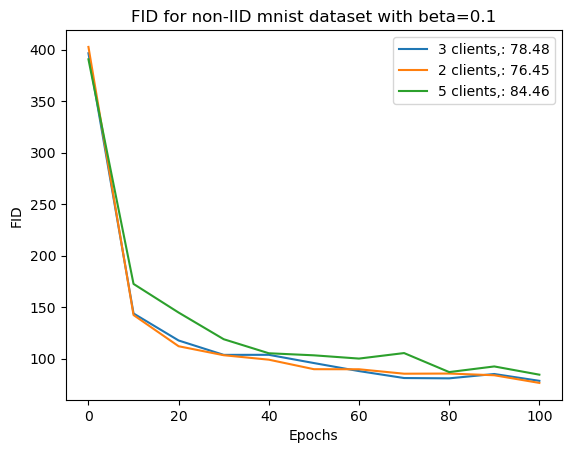

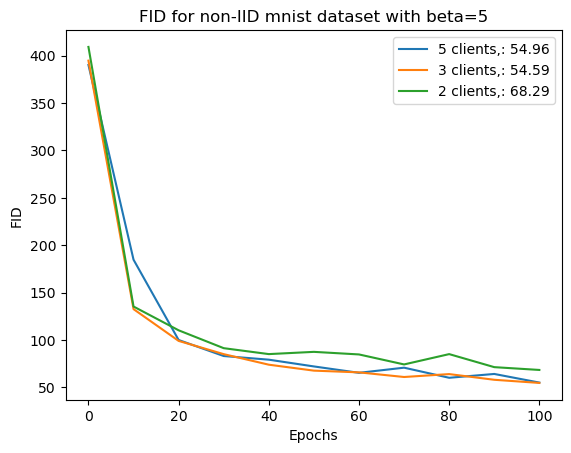

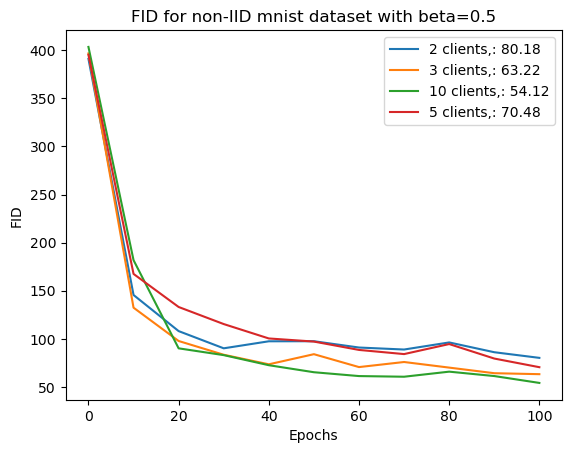

In [138]:
# Plot noniid results for each number of clients and beta value
for beta_val in noniid_results.keys():
    for num_clients in noniid_results[beta_val].keys():
        fid_epoch_dict = noniid_results[beta_val][num_clients]
        max_epoch = max(fid_epoch_dict.keys())
        epochs = range(0, max_epoch + 1, 10)
        try:
            fids = [fid_epoch_dict[e] for e in epochs]
        except:
            print(f"Error for {num_clients} clients and beta={beta_val}")
        plt.plot(epochs, fids, label=f"{num_clients} clients,: {fids[-1]:.2f}")
    plt.legend()
    plt.title(f"FID for non-IID {dataset} dataset with beta={beta_val}")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.show()


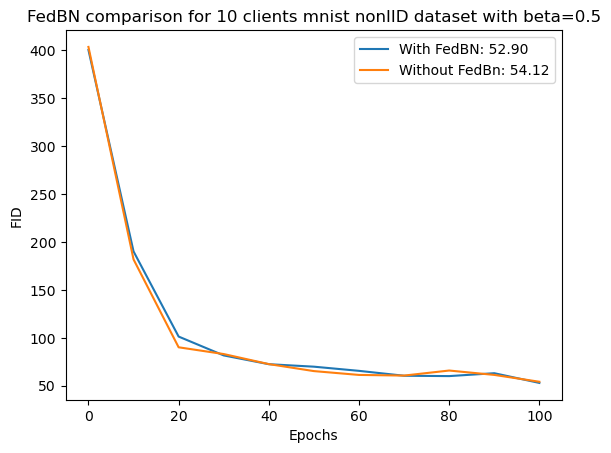

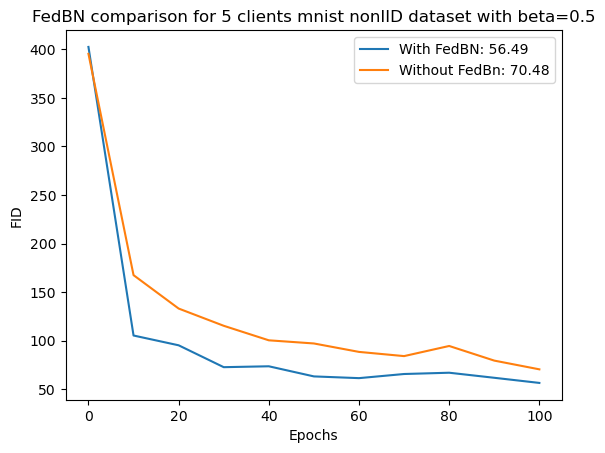

In [139]:
# Plot FEDBN results for each number of clients
for num_clients in fedbn_results.keys():
    fid_epoch_dict = fedbn_results[num_clients]
    max_epoch = max(fid_epoch_dict.keys())
    epochs = range(0, max_epoch+1, 10)
    fed_bn_fids = [fid_epoch_dict[e] for e in epochs]
    
    fid_epoch_dict = noniid_results[0.5][num_clients]
    no_fedbn_fids = [fid_epoch_dict[e] for e in epochs]
    plt.plot(epochs, fed_bn_fids, label=f"With FedBN: {fed_bn_fids[-1]:.2f}")
    plt.plot(epochs, no_fedbn_fids, label=f"Without FedBn: {no_fedbn_fids[-1]:.2f}")

    plt.legend()
    plt.title(f"FedBN comparison for {num_clients} clients MNIST nonIID dataset with beta=0.5")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.show()

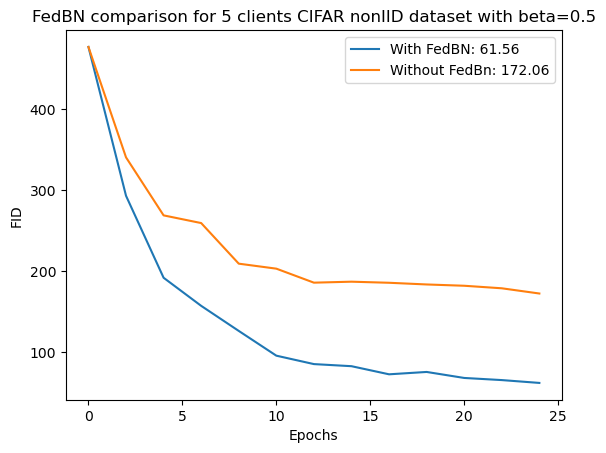

In [141]:
# Plot FEDBN results for each number of clients
for num_clients in fedbn_results_cifar.keys():
    fid_epoch_dict = fedbn_results_cifar[num_clients]
    max_epoch = max(fid_epoch_dict.keys())
    
    epochs = range(0, max_epoch+1, 2)
    fed_bn_fids = [fid_epoch_dict[e] for e in epochs]
    
    fid_epoch_dict = noniid_results_cifar[0.5][num_clients]
    no_fedbn_fids = [fid_epoch_dict[e] for e in epochs]
    plt.plot(epochs, fed_bn_fids, label=f"With FedBN: {fed_bn_fids[-1]:.2f}")
    plt.plot(epochs, no_fedbn_fids, label=f"Without FedBn: {no_fedbn_fids[-1]:.2f}")

    plt.legend()
    plt.title(f"FedBN comparison for {num_clients} clients CIFAR nonIID dataset with beta=0.5")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.show()

In [ ]:
results_dir = "/home/menonsandu/Downloads/multi_disc_results"
for folder in os.listdir(results_dir):
    for file in os.listdir(os.path.join(results_dir, folder)):
        if file.endswith(".zip"):
            # print(os.path.join(results_dir, folder, file))
            !unzip -o -d {results_dir}/{folder}/ {multi_disc_results}/{folder}/{file}

In [159]:
# Multi-disc results
results_dir = "/home/menonsandu/Downloads/multi_disc_results"

# MNIST results
iid_results, noniid_results, fedbn_results = read_results(results_dir, "mnist")
# CIFAR10 results
iid_results_cifar, noniid_results_cifar, fedbn_results_cifar = read_results(results_dir, "cifar")

FID not found for  /home/menonsandu/Downloads/multi_disc_results/mnist_splits_5_5_noniid fid_results_107.txt


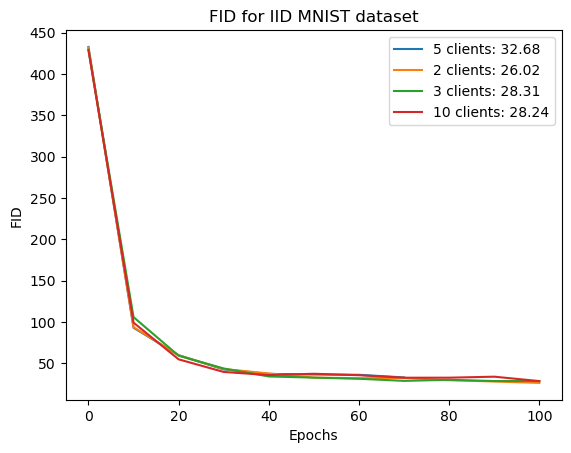

In [154]:
# Plot iid results for each number of clients
for num_clients in iid_results.keys():
    fid_epoch_dict = iid_results[num_clients]
    max_epoch = max(fid_epoch_dict.keys())
    epochs = range(0, max_epoch+1, 10)
    fids = [fid_epoch_dict[e] for e in epochs]
    plt.plot(epochs, fids, label=f"{num_clients} clients: {fids[-1]:.2f}")
plt.legend()
plt.title(f"FID for IID MNIST dataset")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.show()


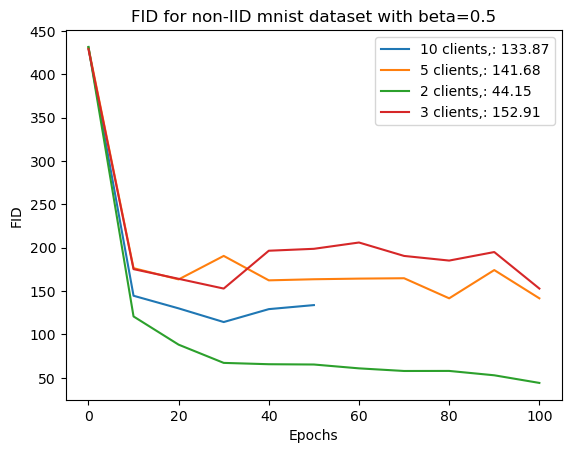

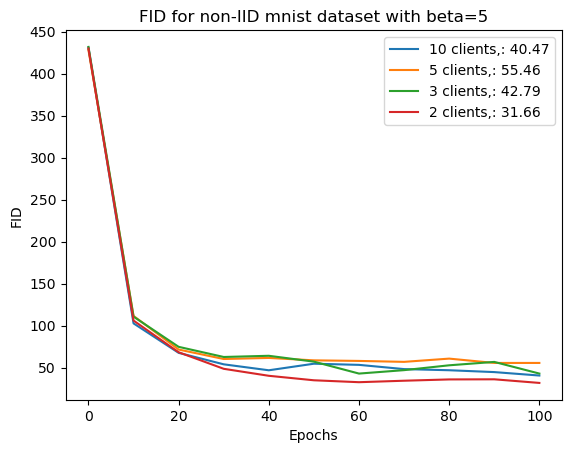

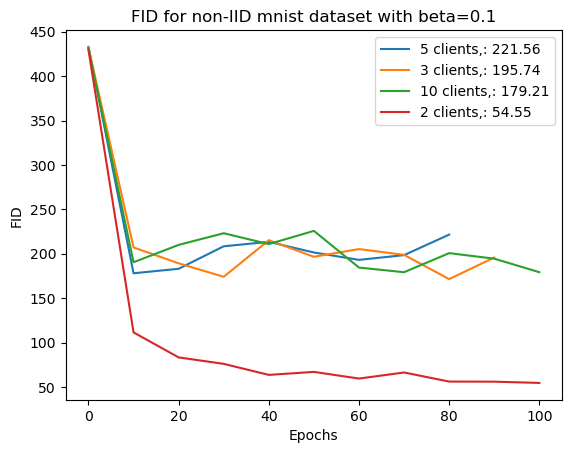

In [160]:
# Plot noniid results for each number of clients and beta value
for beta_val in noniid_results.keys():
    for num_clients in noniid_results[beta_val].keys():
        fid_epoch_dict = noniid_results[beta_val][num_clients]
        max_epoch = max(fid_epoch_dict.keys())
        epochs = range(0, max_epoch + 1, 10)
        try:
            fids = [fid_epoch_dict[e] for e in epochs]
        except:
            print(f"Error for {num_clients} clients and beta={beta_val}")
        plt.plot(epochs, fids, label=f"{num_clients} clients,: {fids[-1]:.2f}")
    plt.legend()
    plt.title(f"FID for non-IID {dataset} dataset with beta={beta_val}")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.show()
